In [20]:
import pandas as pd

In [36]:
timeseries_file_path = '/Users/fionaturner-hehlen/Desktop/EnergyDataHackdays2024/100_15_2021.csv' 
rows = 3504002

df = pd.read_csv(timeseries_file_path, nrows=rows)
df

,id,timestamp,value_kwh,year
0,f75148515d279e2c6c36207fa4002faf,2021-05-08T00:15:00.000Z,0.000,2021
1,f75148515d279e2c6c36207fa4002faf,2021-01-30T06:30:00.000Z,0.000,2021
2,f75148515d279e2c6c36207fa4002faf,2021-01-25T23:15:00.000Z,0.000,2021
3,f75148515d279e2c6c36207fa4002faf,2021-02-03T18:30:00.000Z,0.000,2021
4,f75148515d279e2c6c36207fa4002faf,2021-06-17T19:15:00.000Z,0.000,2021
...,...,...,...,...
3503995,c33ffe928e1b305d0df6ca2639664949,2021-09-05T17:30:00.000Z,0.019,2021
3503996,c33ffe928e1b305d0df6ca2639664949,2021-03-17T12:45:00.000Z,0.020,2021
3503997,c33ffe928e1b305d0df6ca2639664949,2021-04-10T05:15:00.000Z,0.007,2021
3503998,c33ffe928e1b305d0df6ca2639664949,2021-04-18T17:30:00.000Z,0.006,2021


In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Convert timestamp to datetime and extract time-related features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Aggregate consumption data at the household level (by 'id')
grouped_df = df.groupby('id').agg({
    'value_kwh': ['mean', 'std', 'sum', 'max'],  # Consumption statistics
    'hour': ['mean'],  # Average time of consumption
    'day_of_week': ['mean'],  # Average day of week of consumption
    'month': ['mean'],  # Average month of consumption
}).reset_index()

# Flatten multi-level column names
grouped_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in grouped_df.columns]

# Handle NaNs by filling them with 0 (e.g., for households with missing data)
grouped_df.fillna(0, inplace=True)

# Select the features for clustering (drop the 'id' column)
cluster_features = grouped_df.drop(columns=['id'])

# Standardize the features to ensure they are on the same scale
scaler = StandardScaler()
cluster_features_scaled = scaler.fit_transform(cluster_features)

# Apply K-Means clustering to group similar households
kmeans = KMeans(n_clusters=3)  # You can adjust the number of clusters here
grouped_df['cluster'] = kmeans.fit_predict(cluster_features_scaled)

# Now `grouped_df` contains the cluster assignments for each household

grouped_df[['id', 'cluster']]


,id,cluster
0,035293b7f95ace18fc6c574cc4e6cc74,0
1,06073db43f7794a2f614099d64f83ac9,0
2,0b90ea97b6bf30a3ad5e7fb057c31c26,1
3,1261fb4a15612f8080728e82fb1f4402,0
4,1336bea67567c258ed2e7a87cbc5ae0e,0
...,...,...
95,f83103ec0617e957148ed921d2badb69,0
96,f9634e2581b0402be6e7769a297368c7,2
97,fa9803e8b16615617e806e9cf41cf866,0
98,fcbf3027e2b66f76293b973c83349f3b,2


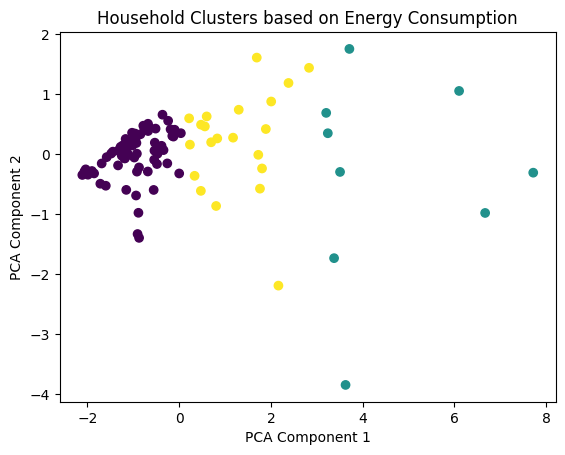

In [50]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cluster_features_scaled)

# Plot the clusters
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=grouped_df['cluster'])
plt.title('Household Clusters based on Energy Consumption')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [53]:
# Ensure the timestamp is a datetime object and sort by timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['id', 'timestamp'])

# Compute the derivative of demand for each household (change in demand)
df['demand_change'] = df.groupby('id')['value_kwh'].diff()

# Check the result
df[['id', 'timestamp', 'value_kwh', 'demand_change']]

,id,timestamp,value_kwh,demand_change
2613412,035293b7f95ace18fc6c574cc4e6cc74,2021-01-01 00:00:00+00:00,0.026,NaN
2473115,035293b7f95ace18fc6c574cc4e6cc74,2021-01-01 00:15:00+00:00,0.047,0.021
1438796,035293b7f95ace18fc6c574cc4e6cc74,2021-01-01 00:30:00+00:00,0.036,-0.011
1771670,035293b7f95ace18fc6c574cc4e6cc74,2021-01-01 00:45:00+00:00,0.065,0.029
686382,035293b7f95ace18fc6c574cc4e6cc74,2021-01-01 01:00:00+00:00,0.030,-0.035
...,...,...,...,...
2965787,ff010cb3b00651e7e6ef2788f7904c08,2021-12-31 22:45:00+00:00,0.010,0.001
3386069,ff010cb3b00651e7e6ef2788f7904c08,2021-12-31 23:00:00+00:00,0.009,-0.001
634643,ff010cb3b00651e7e6ef2788f7904c08,2021-12-31 23:15:00+00:00,0.010,0.001
2053376,ff010cb3b00651e7e6ef2788f7904c08,2021-12-31 23:30:00+00:00,0.469,0.459
